# Testing

Testing a few ideas:
1. Should we remove essential nodes from the graph and then do analysis or do our analysis and remove essential nodes from consideration?
2. Looking for 'intermediate nodes'

In [1]:
import networkx as nx
import numpy as np
import scipy as sp
import pandas as pd

In [2]:
# Reading in graph 
G = nx.read_weighted_edgelist("yeast.txt",comments="#",nodetype=str)

In [3]:
# Deleting edges that don't meet threshold score
threshold_score = 700
for edge in G.edges: 
  weight = list(G.get_edge_data(edge[0],edge[1]).values())
  if(weight[0] <= threshold_score):
    G.remove_edge(edge[0],edge[1])

G = nx.relabel_nodes(G, lambda x: x[5:])

In [12]:
# Removing essential nodes
df = pd.read_csv("essential_proteins.csv", header=None)
essential_proteins = df[1].values

G_essential = G.copy()

for protein in essential_proteins:
  str = protein
  if str in G_essential.nodes:
    G_essential.remove_node(str)

### Discussion Point #1

Closeness centrality is defined as average length of the shortest path between a node $i$ and all other nodes in the graph. Since there is a  correlation between essential nodes and their degree/betweenness centrality, many shortest paths will likely go through these essential nodes (this can be supported). Suppose node $i$ is not an essential node and has many connections to essential nodes, but node $j$ has relatively fewer. This means that removing essential nodes has a disproportionate effect on the closeness centrality of node $i$ compared to node $j$.

In [18]:
cc = nx.algorithms.closeness_centrality(G).items()

cc_essential = nx.algorithms.closeness_centrality(G_essential).items()

In [28]:
cc = sorted(list(cc), key = lambda x: x[1], reverse=True)
cc_essential = sorted(list(cc_essential), key = lambda x: x[1], reverse=True)

# Removing essential nodes from consideration from centrality measure
cc = [(node, val) for node, val in cc if node not in essential_proteins]

for i in range(0, 20):
  print(i, cc[i][0], cc_essential[i][0])

0 YMR186W YEL021W
1 YEL021W YMR186W
2 YMR116C YLL013C
3 YLL013C YMR116C
4 YPR080W YPR080W
5 YML063W YLR178C
6 YBR010W YLL026W
7 YLR441C YBR010W
8 YLL039C YLL039C
9 YGR192C YGR192C
10 YJR066W YGR088W
11 YKL009W YEL009C
12 YFR031C-A YKR094C
13 YIL018W YJR066W
14 YKL081W YBR251W
15 YKR094C YLR441C
16 YBL099W YIL148W
17 YDR101C YMR250W
18 YJR113C YMR105C
19 YEL009C YML063W


In [30]:
# Finding non-essential proteins with highest proportional connection to essential proteins
d = {}

for i in G.nodes:
  if i not in essential_proteins and G.degree(i) != 0:
    num_essential_neighbours = 0
    for j in G[i]:
      if j in essential_proteins:
        num_essential_neighbours += 1
    
    d[i] = num_essential_neighbours/G.degree(i)

d_list = sorted(list(d.items()), key = lambda x: x[1], reverse=True)

In [32]:
print(d_list[:20])

[('YEL052W', 1.0), ('YJR127C', 1.0), ('YDR338C', 1.0), ('YOR113W', 1.0), ('YJL103C', 1.0), ('YGR109W-B', 1.0), ('YOL045W', 1.0), ('YKR061W', 1.0), ('YMR291W', 1.0), ('YKR051W', 1.0), ('YOR320C', 1.0), ('YKL051W', 1.0), ('YLR302C', 1.0), ('YIL055C', 1.0), ('YLR146W-A', 1.0), ('YBL009W', 1.0), ('YDR528W', 1.0), ('YBL025W', 1.0), ('YOR183W', 1.0), ('YDR524W-C', 1.0)]


In [35]:
print(nx.algorithms.closeness_centrality(G, u = 'YEL052W'))
print(nx.algorithms.closeness_centrality(G_essential, u = 'YEL052W'))

0.23232507778191047
0.0


So, it becomes clear that a non-essential node such as "YEL052W", whose neighbours are all essential nodes, has a zero closeness centrality if we consider the graph with essential nodes removed, but otherwise is a fairly central node in the network.

This problem is not unique to closeness centrality - the node "YEL052W" becomes isolated when all essential proteins are removed, so it has a zero centrality.

### Discussion Point #2
We will check if there are isolated nodes in the NAFLD network. If there are, we see how many and look for 'intermediate nodes' (that are obviously not NAFLD nodes) to link them.

See:

- https://cs.stackexchange.com/questions/93047/minimal-number-of-nodes-needed-to-connect-a-disconnected-graph
- node-weighted steiner problem
- connected vertex cover
- steiner tree (using networkx) but with edge weights of 1.

In [4]:
# Getting list of all yeast homologs
df = pd.read_csv("human_to_yeast.csv")

# Note: some homologs in this list may also be present in the essential nodes list, so they wont be included in the subgraph.
homologs = list(set(list(df["homolog_systematic_name"])))

In [5]:
# Getting subgraph induced by all yeast homologs
NAFLD = G.subgraph(homologs).copy()

In [7]:
print(list(nx.isolates(NAFLD)))

['YDL219W', 'YML087C', 'YMR212C', 'YMR222C', 'YLL061W', 'YCR026C', 'YCR028C-A', 'YLR001C', 'YLL055W', 'YDR236C', 'YBR046C', 'YEL016C', 'YCR028C', 'YML125C', 'YBL057C', 'YAL067C', 'YKR013W', 'YOL119C', 'YER159C', 'YBR233W', 'YDR105C', 'YGR065C', 'YPR131C', 'YHR078W', 'YHR032W', 'YDR371W', 'YLR004C', 'YJL079C', 'YDR221W', 'YJR001W', 'YCR075C', 'YOR093C', 'YER140W', 'YPR058W', 'YJR085C', 'YOR280C', 'YOR256C', 'YBR210W', 'YBR104W', 'YLL048C', 'YPL088W', 'YJR100C', 'YKL198C', 'YDR151C', 'YDR338C', 'YGL159W', 'YJR126C', 'YGL096W', 'YDR372C']


In [6]:
# Create separate graph where all edge weights are 1
H = G.copy()
for (u, v, d) in H.edges().data():
  d['weight'] = 1

In [8]:
for node in homologs:
  if node not in nx.isolates(NAFLD) and node in H.nodes():
    H.remove_node(node)

GC = H.subgraph(max(nx.connected_components(H), key=len)).copy()

In [11]:
print(GC)

Graph with 5093 nodes and 81420 edges


In [12]:
isolated = []

for node in list(nx.isolates(NAFLD)):
  if node in GC.nodes():
    isolated.append(node)

print(len(isolated))
print(isolated)
print(GC)

46
['YDL219W', 'YML087C', 'YMR212C', 'YLL061W', 'YCR026C', 'YCR028C-A', 'YLR001C', 'YLL055W', 'YDR236C', 'YBR046C', 'YCR028C', 'YML125C', 'YBL057C', 'YAL067C', 'YKR013W', 'YOL119C', 'YER159C', 'YBR233W', 'YDR105C', 'YGR065C', 'YPR131C', 'YHR078W', 'YDR371W', 'YLR004C', 'YJL079C', 'YDR221W', 'YJR001W', 'YCR075C', 'YOR093C', 'YER140W', 'YPR058W', 'YJR085C', 'YOR280C', 'YOR256C', 'YBR210W', 'YBR104W', 'YLL048C', 'YPL088W', 'YJR100C', 'YKL198C', 'YDR151C', 'YDR338C', 'YGL159W', 'YJR126C', 'YGL096W', 'YDR372C']
Graph with 5093 nodes and 81420 edges


In [14]:
T = isolated

# Parameters
name = "Yeast PPIN with non-isolated nodes associated with NAFLD removed"
creator = "A. Habibi"

f = open("NAFLD_graph.stp", "w")

# Header
f.write("33D32945 STP File, STP Format Version 1.0\n\n")

# Comments
f.write("SECTION Comment\n")
f.write(f"Name\t\"{name}\"\n")
f.write(f"Creator\t\"{creator}\"\n")
f.write("END\n\n")

# Graph
f.write("SECTION Graph\n")
n = GC.number_of_nodes()
m = GC.number_of_edges()
f.write(f"Nodes {n}\n")
f.write(f"Edges {m}\n")

# STP requires nodes to be represented by positive integers. So, we use index + 1 of nodes in node list of G.
node_key = {}
for index, node in enumerate(GC.nodes()):
  node_key[node] = index + 1

for (u, v, d) in GC.edges().data():
  f.write(f"E {node_key[u]} {node_key[v]} {int(d['weight'])}\n")
f.write("END\n\n")

# Terminals
f.write("SECTION Terminals\n")
f.write(f"Terminals {len(T)}\n")
for t in T:
  f.write(f"T {node_key[t]}\n")
f.write("END\n\n")

f.write("EOF")

f.close()

Running SCIP-Jack...

In [33]:
# Creating spanning tree
ST = nx.Graph()

f = open("NAFLD_graph.stplog")

l = f.readlines()

# Moving to final solution section
i = l.index("SECTION Finalsolution\n")

# Finding number of vertices
n = int(l[i + 1].split(" ")[1])

# Moving pointer down to start of vertices
i += 2
nodes = list(GC.nodes())

for j in range(0, n):
  node = int(l[i + j].split(" ")[1])
  ST.add_node(nodes[node - 1])

print(ST)

# Since this is a tree, there will be n - 1 edges

i += 101
for j in range(0, n-1):
  u, v = int(l[i + j].split(" ")[1]), int(l[i + j].split(" ")[2])
  ST.add_edge(nodes[u - 1], nodes[v - 1], weight = 1)

print(ST)

f.close()

Graph with 100 nodes and 0 edges
Graph with 100 nodes and 99 edges


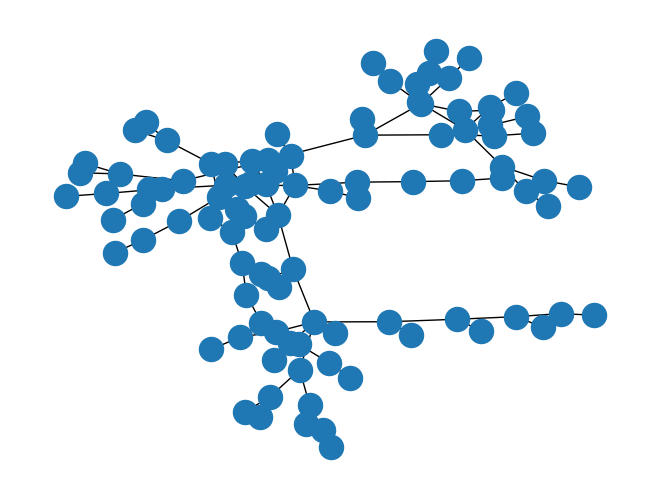

In [34]:
nx.draw(ST)